In [9]:
import os
import re

import numpy as np
import torch

### 定义几个辅助函数：
↓👇这个用来干啥来着，我还没搞清楚（之后记得把这行改掉


In [10]:
def load_cab_vector():
    word_list = []
    vocabulary_vectors = []
    data = open('data/glove.6B.50d.txt', encoding='utf-8')
    for line in data.readlines():
        temp = line.strip('\n').split(' ')  # 一个列表
        name = temp[0]
        word_list.append(name.lower())
        vector = [temp[i] for i in range(1, len(temp))]  # 向量
        vector = list(map(float, vector))  # 变成浮点数
        vocabulary_vectors.append(vector)
    # 保存
    vocabulary_vectors = np.array(vocabulary_vectors)
    word_list = np.array(word_list)
    np.save('npys/vocabulary_vectors', vocabulary_vectors)
    np.save('npys/word_list', word_list)
    return vocabulary_vectors, word_list
load_cab_vector()

(array([[ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
         -0.78581 ],
        [ 0.013441,  0.23682 , -0.16899 , ..., -0.56657 ,  0.044691,
          0.30392 ],
        [ 0.15164 ,  0.30177 , -0.16763 , ..., -0.35652 ,  0.016413,
          0.10216 ],
        ...,
        [-0.51181 ,  0.058706,  1.0913  , ..., -0.25003 , -1.125   ,
          1.5863  ],
        [-0.75898 , -0.47426 ,  0.4737  , ...,  0.78954 , -0.014116,
          0.6448  ],
        [ 0.072617, -0.51393 ,  0.4728  , ..., -0.18907 , -0.59021 ,
          0.55559 ]]),
 array(['the', ',', '.', ..., 'rolonda', 'zsombor', 'sandberger'],
       dtype='<U68'))

↓👇这个用来从文件中加载原始文本数据并处理成单词列表

In [11]:
def load_data(path, flag='train'):
    labels = ['pos', 'neg']
    data = []
    r = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n。！，]+'
    compiled = re.compile(r)
    for label in labels:
        files = os.listdir(os.path.join(path, flag, label))
        # 去除标点符号
        cnt=0
        for file in files:
            with open(os.path.join(path, flag, label, file), 'r', encoding='utf8') as rf:
                temp = rf.read()
                temp = temp.replace('\n', ' ').replace('<br /><br />', ' ')
                if cnt<2:
                    cnt+=1
                    print(temp)
                temp = re.sub(r, ' \g<0> ', temp)
                temp = temp.split(' ')
                temp = [temp[i].lower() for i in range(len(temp)) if temp[i] != '']
                if label == 'pos':
                    data.append([temp, 1])
                elif label == 'neg':
                    data.append([temp, 0])
            #break # Remember to delete this
    return data

测试一下，看看数据发育正不正常啊

In [12]:
train_data = load_data('./data/aclImdb/')
print(train_data[0])

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.
Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The

In [13]:
def process_sentence(flag):
    sentence_code = []
    #vocabulary_vectors = np.load('npys/vocabulary_vectors.npy', allow_pickle=True)
    word_list = np.load('npys/word_list.npy', allow_pickle=True)
    word_list = word_list.tolist()
    word2index={}
    length=[]
    for i in range(1000):
        length.append(0)
    for i in range (len(word_list)):
        word2index[word_list[i]]=i
    test_data = load_data('data/aclImdb', flag)
    cnt=0
    for i in range(len(test_data)):
        # print(i)
        vec = test_data[i][0]
        temp = []
        index = 0
        for j in range(len(vec)):
            try:
                index = word2index[vec[j]]
            except KeyError:  # 没找到
                index = 399999
            finally:
                temp.append(index)  # temp表示一个单词在词典中的序号
        
        l=len(temp)
        if(l>=1000):
            l=999
        length[l]+=1
        if l < 250:
            for k in range(l, 250):  # 不足补0
                temp.append(0)
        else:
            temp = temp[0:250]  # 只保留250个
        sentence_code.append(temp)
        if cnt<2:
            cnt+=1
            print(temp)
    print(length)
    # print(sentence_code)

    sentence_code = np.array(sentence_code)
    if flag == 'train':
        np.save('npys/sentence_code_1', sentence_code)
    else:
        np.save('npys/sentence_code_2', sentence_code)
    return length
result=process_sentence("train")
process_sentence("test")


For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.
Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 0,
 3,
 3,
 4,
 1,
 1,
 7,
 4,
 6,
 6,
 4,
 6,
 7,
 12,
 8,
 14,
 11,
 11,
 16,
 7,
 24,
 14,
 32,
 25,
 21,
 30,
 28,
 32,
 42,
 36,
 46,
 38,
 48,
 34,
 33,
 47,
 38,
 64,
 44,
 43,
 37,
 35,
 43,
 41,
 50,
 60,
 38,
 38,
 41,
 47,
 48,
 42,
 41,
 43,
 48,
 35,
 45,
 45,
 29,
 38,
 40,
 38,
 44,
 42,
 27,
 47,
 35,
 32,
 43,
 35,
 51,
 41,
 48,
 46,
 44,
 34,
 25,
 37,
 33,
 41,
 47,
 53,
 35,
 42,
 41,
 40,
 43,
 43,
 52,
 43,
 55,
 46,
 66,
 62,
 59,
 72,
 56,
 66,
 76,
 63,
 75,
 70,
 92,
 87,
 97,
 100,
 84,
 92,
 107,
 116,
 104,
 95,
 115,
 135,
 137,
 127,
 138,
 154,
 126,
 141,
 139,
 153,
 136,
 158,
 173,
 155,
 139,
 151,
 166,
 152,
 127,
 151,
 137,
 164,
 152,
 141,
 115,
 141,
 115,
 114,
 139,
 111,
 113,
 112,
 109,
 127,
 119,
 105,
 119,
 95,
 106,
 106,
 127,
 104,
 105,
 95,
 108,
 88,
 99,
 103,
 108,
 98,
 116,
 99,
 90,
 78,
 80,
 86,
 95,
 106,
 88,
 86,
 82,

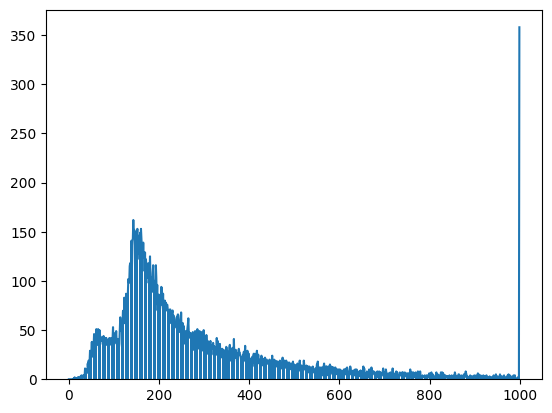

In [22]:
import matplotlib.pyplot as plt
plt.bar(x=range(1000),height=result)
plt.plot(result)